What is a random forest model? A random forest model is based on the concept of a decision tree (but applied over an ensemble).  Random forest models can be applied to regression problems as well as classification problems; here, we'll look at a regression problem using Python's <code>sklearn</code> package. <br>  

Unlike a standard linear regression model, a random forest regression model does not make any a priori assumptions about the data--we don't have to assume it's normal, or that any trends or relationships are linear. <br>

Not only can we try to fit a model and make predictions, we can also use the information in the algorithm to identify the key predictors (and which predictors are not really adding any information to our model). <br>

As with most machine learing / data science approaches, experimental design is key.  Physical intuition about the system you are trying to predict is key--you need to be able to identify the important variables (if you don't include a variable, you can't analyze its relationship with the predictand), get the relevant data and model output, and select the timescales of interest, among other things. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Read in example temperature data for one year's worth of temperatures in Seattle.  All temperatures given in degrees Fahrenheit

In [3]:
features = pd.read_csv('temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


<code>temp_2</code>: temperature 2 days earlier<br>
<code>temp_1</code>: temperature 1 day earlier<br>
<code>average</code>: hist. average max temp <br>
<code>actual</code>: actual max temp <br>
<code>forecast_noaa</code>, <code>forecast_acc</code>, <code>forecast_under</code>: NOAA, Accuweather forecasts

In [4]:
print('Shape of features is: ',features.shape)

Shape of features is:  (348, 12)


Get statistics for each column using <code>describe()</code>

In [5]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


Quick plots of <code>actual, temp_2, temp_1</code> and different model estimates

Text(0.5, 1.0, 'Maximum Temperature Predictors')

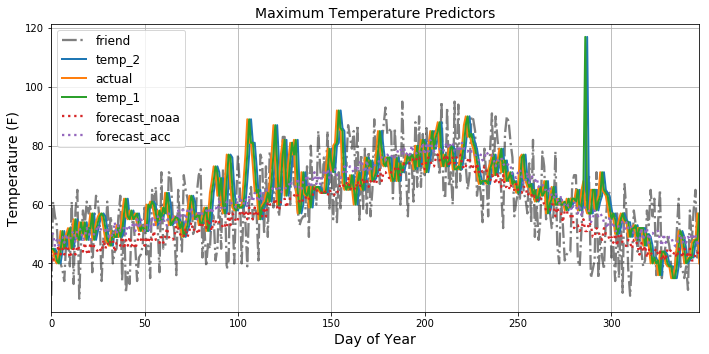

In [6]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1.5,1])
features.plot(y='friend',ax=ax1,linestyle='-.',linewidth=2.3,color='k',alpha=0.5)
features.plot(y={'temp_2','temp_1','actual'},ax=ax1,linewidth=2)
features.plot(y={'forecast_noaa','forecast_acc'},ax=ax1,linestyle=':',linewidth=2.3)
ax1.set_ylabel('Temperature (F)',fontsize=14)
ax1.set_xlabel('Day of Year',fontsize=14)
ax1.grid()
ax1.legend(fontsize=12)
ax1.set_title('Maximum Temperature Predictors',fontsize=14)

We see that we have an outlier for <code>temp_2</code> and <code>temp_1</code>...for real research, we'd probably flag this value.  Otherwise though things look reasonable, with our actual and forecast temperatures sharing roughly the same seasonality. 

One-hot encoding with <code>get_dummies()</code>. This step turns our non-numeric data into binary data. In this case, our days of the week column (Mon-Sun) gets expanded into 7 columns.  Mondays will have a <code>1</code> in <code>week_Mon</code> and a <code>0</code> in <code>week_Tues</code>, <code>week_Weds</code>, etc.

In [7]:
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


Identify predictands (what we want to predict).  In this case, we want to predict <code>actual</code>. We'll call the predictions <code>labels</code>. Our predictors (what we're using to precit <code>actual</code>) will continue to be called <code>features</code>. Need to convert pandas array to numpy for algorithm. <br>
As you can imagine, designating and including predictors is (<code>features</code>) 

In [8]:
labels = np.array(features['actual'])
features = features.drop('actual',axis=1) # drop our predictand from the predictors

In [9]:
feature_list = list(features.columns) # list of feature names (predictand names)
features_ar = np.array(features)

Split data into training and testing set with <code>train_test_split</code>.  In this example, we'll reserve 25% of the data for testing

In [42]:
train_features, test_features, train_labels, test_labels = train_test_split(features_ar,labels,test_size=0.25)
print('Training features shape:',train_features.shape)
print('Training labels shape:',train_labels.shape)
print('Testing features shape:',test_features.shape)
print('Testing labels shape:',test_labels.shape)

Training features shape: (261, 17)
Training labels shape: (261,)
Testing features shape: (87, 17)
Testing labels shape: (87,)


Establish baseline prediction.  In this case, we use the historical maximum average T (<code>average</code>).  This can be thought of as our climatology--the prediction we make based only on historical temperature measurements.  In this example, we'll use mean absolute error (<code>MAE</code>), but we could use a different metric, such as RMSE, as well. The average baseline error is going to change slightly every time we re-sort our training and testing data, but it should be +/- 5 F. 

In [43]:
baseline_preds = test_features[:,feature_list.index('average')]
baseline_errors = abs(baseline_preds - test_labels)
MAE_base = round(np.mean(baseline_errors),2)
print('average baseline error:',MAE_base,' degrees F')

average baseline error: 4.94  degrees F


Now, apply the random forest model to the training data set.  For this example, we'll use 500 estimators.  That means we'll make 500 different decision trees.  

In [44]:
rf = RandomForestRegressor(n_estimators=1000,criterion='mae')
rf.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Now, use the model to predict the test labels using the test features.  Note that we're evaluating our model with the mean absolute error (MAE)

In [50]:
predictions = rf.predict(test_features)
prediction_errors = abs(predictions - test_labels) #mean absolute error between predicted and actual temps
MAE = round(np.mean(prediction_errors),2)
print('mean absolute error: ',MAE,' degrees.')
if MAE <= MAE_base:
    print('yay! the model is better than our "climatology"')
else: 
    print('poop. the model is no better than "climatology"')

mean absolute error:  3.75  degrees.
yay! the model is better than our "climatology"


Now, we can calculate our mean absolute percentage error (MAPE)

In [51]:
mape = 100*(prediction_errors/test_labels)
print('Accuracy: ',round((100-np.mean(mape)),2),'%')

Accuracy:  94.08 %


And we can identify key features using <code>feature_importances_</code>.  From the bar plot below, we can see that yeseterday's temperature (<code>temp_1</code>) is the best predictor of temperature, followed by historical average temperature (<code>average</code>).  Among the forecasts, we can see that the Accuweather forecast is a better predictor than NOAA and your friend's predictions.  We can see that day of the week is not a useful predictor. If we were to try to refine this model, we could probably drop some of these predictors (like day of the week).  

Text(0.5, 1.0, 'feature importance')

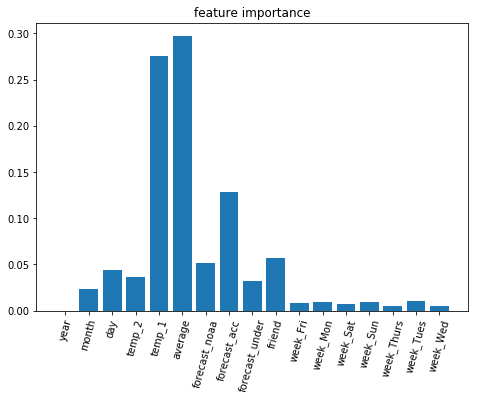

In [55]:
pred_rank = rf.feature_importances_
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
ax1.bar(np.arange(0,len(pred_rank)),pred_rank)
ax1.set_xticks(np.arange(0,len(pred_rank)))
ax1.set_xticklabels(feature_list,rotation=75)
ax1.set_title('feature importance')